In [1]:
!pip install tensorflow-gpu==2.0.0

In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools

import tensorflow as tf 
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.0.0


In [3]:
# create CNN Model

class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth) # (h, h, chanel)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model


In [5]:
DATASET = "dataset"  # this folde must contain three subfolder with images
MODEL = "Scene.model" # name to store the model on disk
PLOT = "plot.png" # plot name

In [6]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
os.chdir("/content/drive/MyDrive/PGAA08_Deep_Learning/Code Files/5. CNN Project")

In [8]:
!dir

ann_local_requirements.txt  dataset.rar     test_examples.rar
CNN\ DEMO.ipynb		    FINAL_CNN.html


In [ ]:
!pip install patool

In [10]:
import patoolib
patoolib.extract_archive("dataset.rar")

patool: Extracting dataset.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/MyDrive/PGAA08_Deep_Learning/Code Files/5. CNN Project/dataset.rar"
patool:     with cwd='./Unpack_px5qkw_e'
patool: ... dataset.rar extracted to `dataset'.


'dataset'

In [11]:
patoolib.extract_archive("test_examples.rar")

patool: Extracting test_examples.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/MyDrive/PGAA08_Deep_Learning/Code Files/5. CNN Project/test_examples.rar"
patool:     with cwd='./Unpack_aybep6qc'
patool: ... test_examples.rar extracted to `test_examples'.


'test_examples'

In [7]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(DATASET)))
random.seed(42)
random.shuffle(imagePaths)

# progress bar 
with tqdm(total=len(imagePaths)) as pbar:
    
    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        

        if label == "Buildings":
            label = 0
        elif label == "Forest":
            label = 1
        elif label == "Sea":
            label = 2

        # print("pr: ", label)	

        labels.append(label)
        
        # update the progressbar
        pbar.update(1)

[INFO] loading images...


In [8]:
data[0]

array([[[237., 209., 198.],
        [240., 215., 205.],
        [237., 215., 204.],
        ...,
        [188., 143., 116.],
        [200., 156., 125.],
        [195., 138., 106.]],

       [[235., 207., 192.],
        [232., 210., 198.],
        [236., 217., 209.],
        ...,
        [214., 169., 145.],
        [182., 117.,  80.],
        [174., 113.,  77.]],

       [[228., 199., 184.],
        [243., 219., 206.],
        [245., 225., 214.],
        ...,
        [206., 154., 123.],
        [209., 156., 120.],
        [181., 118.,  81.]],

       ...,

       [[155., 164., 172.],
        [143., 152., 165.],
        [137., 149., 155.],
        ...,
        [ 66.,  57.,  54.],
        [ 17.,   9.,   7.],
        [ 14.,   6.,   6.]],

       [[ 97., 113., 129.],
        [113., 129., 141.],
        [119., 130., 140.],
        ...,
        [ 19.,  15.,  16.],
        [ 27.,  25.,  23.],
        [ 15.,  12.,  12.]],

       [[147., 159., 169.],
        [138., 149., 158.],
        [127., 1

In [9]:
data[0].shape

(28, 28, 3)

In [10]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [11]:
labels

array([0, 1, 0, ..., 0, 0, 2])

In [12]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [13]:
trainX.shape

(994, 28, 28, 3)

In [14]:
trainY.shape

(994,)

In [15]:
trainY = to_categorical(trainY, num_classes=3)
testY = to_categorical(testY, num_classes=3)

In [23]:
trainY[0]

array([1., 0., 0.], dtype=float32)

# Data Preprocessing (Augumentation)

In [24]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [27]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=3)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")

[INFO] compiling model...
[INFO] model complied...


In [28]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        1520      
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0

In [29]:
# train the network
print("[INFO] training network...")
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY), 
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS, 
              verbose=1)

[INFO] training network...
Train for 31 steps, validate on 332 samples
Epoch 1/25
31/31 [==============================] - 5s 151ms/step - loss: 0.9827 - accuracy: 0.5114 - val_loss: 0.8398 - val_accuracy: 0.5090
Epoch 2/25
31/31 [==============================] - 1s 18ms/step - loss: 0.8029 - accuracy: 0.6102 - val_loss: 0.7689 - val_accuracy: 0.5873
Epoch 3/25
31/31 [==============================] - 1s 18ms/step - loss: 0.6803 - accuracy: 0.7141 - val_loss: 0.8635 - val_accuracy: 0.6536
Epoch 4/25
31/31 [==============================] - 1s 18ms/step - loss: 0.7263 - accuracy: 0.6798 - val_loss: 0.5829 - val_accuracy: 0.7590
Epoch 5/25
31/31 [==============================] - 1s 18ms/step - loss: 0.6178 - accuracy: 0.7370 - val_loss: 0.6036 - val_accuracy: 0.7470
Epoch 6/25
31/31 [==============================] - 1s 18ms/step - loss: 0.5565 - accuracy: 0.7827 - val_loss: 0.5184 - val_accuracy: 0.7801
Epoch 7/25
31/31 [==============================] - 1s 18ms/step - loss: 0.4929 - 

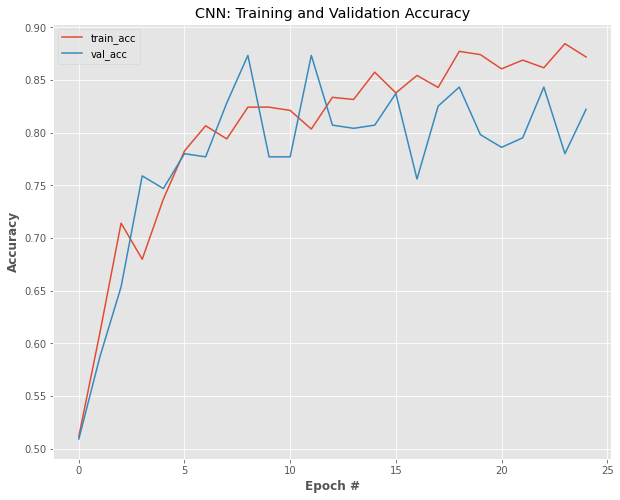

In [31]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

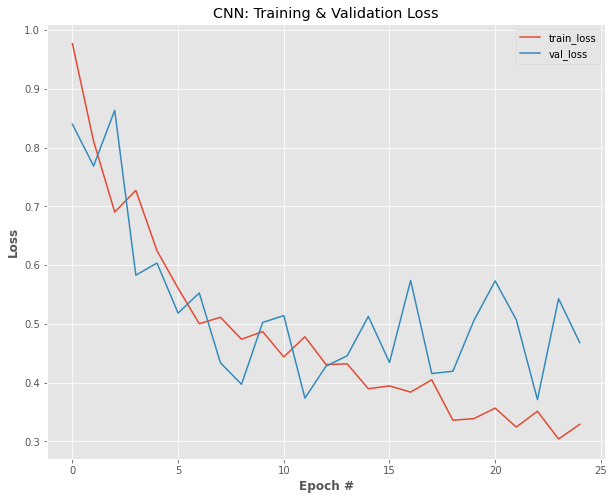

In [32]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

In [33]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    plt.grid(b=None)
    ax = fig.add_subplot(111)
    ax.imshow(img)

In [35]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model 
print("[INFO] loading network and...")
# model = load_model(MODEL)

# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('test_examples')))   # data folder with 2 categorical folders

all_class = ["Buildings", "Forest", "Sea"]


# progress bar 
with tqdm(total=len(testImagePaths)) as pbar:
    
    for imagePath in testImagePaths:
        
        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf = model.predict(image)[0]

        # build the label
        label = all_class[np.argmax(prd_conf)]
        proba = prd_conf[np.argmax(prd_conf)]

        label = "{}: {:.2f}%".format(label, proba * 100)

        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 0, 0), 2)
        
        # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)
        
        pbar.update(1)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install gradio

In [37]:
import gradio as gr

In [38]:
def predict_image(image):
    # load the image
    
    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

        
    preds = model.predict(image)[0]
    result = dict()
    result["Buildings"] = round(float(list(preds)[0]), 3)
    result["Forest"] = round(float(list(preds)[1]), 3)
    result["Sea"] = round(float(list(preds)[2]), 3)
    
    print(result)
    
    return result

In [39]:
im = gr.inputs.Image(shape=(32,32))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(fn=predict_image, inputs=im, outputs=label, capture_session=True, title="CNN Demo").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://13520.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7fd47ff34410>,
 'http://127.0.0.1:7860/',
 'https://13520.gradio.app')

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.0.0
{'Buildings': 0.0, 'Forest': 0.012, 'Sea': 0.988}
{'Buildings': 0.0, 'Forest': 0.012, 'Sea': 0.988}
